#Introdução

Grupo: Germano Barcelos (3873), Guilherme Melos (3882), Jhonata Miranda (3859)

Neste trabalho é apresentado um método de extração de características geográficas de uma imagem de uma região. O trabalho proposto baseia-se na análise e extração das características de textura da geografia local. Durante a identificação, a imagem original é recortada em pequanas partes e nomeadas para que se possa saber a qual tipo de área se referem. Na sequência, as informações de textura são extraídas através de uma abordagem estatística de segunda ordem, utilizando as características de Haralick como parâmetros de classificação. As informações obtidas são armazenadas em um dataframe de características, realizamos o PCA para extrair somente os componentes que descrevem 95% da variância dos dados, e usamos um classificador SVM para a classificação das iamgens. Por fim, utilizamos um K-means para a clusterização da imagem original. 

Para realizar este trabalho, utilzamos algumas bibliotecas indispensáveis para o processamento de imagens, tais como: `OpenCv`, `Numpy`, `Pandas` e `MatPlotLib`. 

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Inicalmente, realizamos 5 recortes da imagem `itai-sp.png` e desses recortes criamos imagens de tamanho 20x20px para extraimos os dados. Abaixo está o procedimento que utilizamos para realizar os recortes.

In [ ]:
img = cv2.imread('./cropped/area-plantada.png')

In [ ]:
img.shape

(530, 842, 3)

In [ ]:
for x in range(0, 530, 20):
    for y in range(0, 842, 20):
        if (img[x:x+20, y:y+20].flatten().sum() != 306000):
            cv2.imwrite(f"./imgs_cropped/area-plantada/{x}-{y}.jpg",img[x:x+20, y:y+20])

#Textura

A análise de imagens através de texturas é um método bastante utilizado na
diferenciação de estruturas encontradas na natureza. Dentre estas estruturas podem ser citadas como exemplo imagens geológicas, imagens biométricas e imagens médicas como mamogratias e ressonâncias magnéticas, etc. Vários tipos de características podem ser extraídas através do estudo da textura de uma imagem, fornecendo informações muito relevantes em sistemas de visão computacional. Textura pode ser definida como um conjunto de determinados padrões que podem ocorrer na natureza, apresentando um formato repetitivo ou não. As imagens de estrutmas geológicas, como reservatórios rochosos aparecem como exemplos de texturas não repetitivas.


## Extração de Características com Halarick

Abaixo, extraimos as caracteristicas de cada uma das imagens recortadas da imagem principal. A função `extract_features()` calcula 5 características da imagem utilizando as funções `greycomatrix()` e `greycoprops()` da biblioteca skimage. A imagem é convertida para o formato de byte sem sinal e, apos isso, utilizamos esta imagem para extrair a matriz de coocorrência da imagem e dessa matriz extraimos caracteristicas como: contraste, energia, homogeneidade, correlação e dissimilaridade.

Com isso, utilizamos a função `extract_features()` para extrair estas caracteristicas de cada um dos recortes criados anteriormente. Por fim, construimos um dataframe com cada uma das colunas sendo as caracteristicas, a última coluna é a classe a qual o recorte pertence, e os dados dessas colunas são os dados obtidos anteriormente.

In [ ]:
import os
from glob import glob
import skimage
from skimage.feature import greycomatrix, greycoprops


def extract_features(image):
    # calcula descritores de halarick para  4 adjacencias
    image = skimage.img_as_ubyte(image)
    bins = np.array([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255]) #16-bit
    inds = np.digitize(image, bins)

    max_value = inds.max()+1
    glcm = greycomatrix(inds, [10], [0], max_value, symmetric=False, normed=True)
    contrast = greycoprops(glcm, 'contrast')[0][0]
    energy = greycoprops(glcm, 'energy')[0][0]
    homogeneity = greycoprops(glcm, 'homogeneity')[0][0]
    correlation = greycoprops(glcm, 'correlation')[0][0]
    dissimilarity = greycoprops(glcm, 'dissimilarity')[0][0]
    
    textures = [contrast, energy, homogeneity, correlation, dissimilarity]  
    
    return textures

base_path = "./imgs_cropped/"
arr = ["area-nao-plantada", "area-plantada", "cidade", "desmatamento", "terra"]

df = []
for x in arr:
    files = glob(os.path.join(base_path, x, "*.jpg"))
    cls = os.path.normpath(files[0]).split("/")[1]

    for f in files:        
        img = cv2.imread(f)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        halarick = extract_features(gray)
        halarick.append(cls)

        df.append(tuple(halarick))

df = pd.DataFrame(df, columns=["contrast", "energy", "homogeneity", "correlation", "dissimilarity", "class"])


Abaixo, exibimos parte do nosso dataframe:

In [ ]:
df

,contrast,energy,homogeneity,correlation,dissimilarity,class
0,2.665,0.258747,0.533781,0.170052,1.215,area-nao-plantada
1,2.640,0.372156,0.598299,0.582060,1.080,area-nao-plantada
2,1.680,0.366674,0.699294,0.743707,0.780,area-nao-plantada
3,4.760,0.306349,0.429198,0.476818,1.700,area-nao-plantada
4,4.645,0.336006,0.479667,-0.160503,1.565,area-nao-plantada
...,...,...,...,...,...,...
103,0.095,0.897636,0.952500,0.125630,0.095,terra
104,0.170,0.841071,0.915000,-0.078905,0.170,terra
105,0.855,0.549636,0.749486,-0.100802,0.555,terra
106,4.330,0.533807,0.724764,0.509120,1.040,terra


## Treinamento

Utilizando as bibliotecas `sklearn` e `seaborn`, iremos treinar um classificador com o dataframe criado acima.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import svm
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit

Aqui, realizamos a separação dos dados de treinamento e dados de validação. Com esses dados, realizamos a PCA (*Principal Component Analisys*), extraindo apenas os componentes que descrevem 95% da variância dos dados. Por fim, exibimos a explicação sobre a taxa de variância dos dados. Nota-se que apenas 3 componentes já descrevem 95% da variância dos dados, sendo desnecessário utilizar o restante dos componentes para treinar o classificador.

In [ ]:
X = df.drop("class", axis=1)
Y = df["class"]

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5, random_state=0, stratify=Y)

In [ ]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

pca = PCA(n_components=0.95, copy=True, whiten=False)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

print(pca.explained_variance_ratio_)

[0.69910896 0.20581668 0.07675125]


Criamos o classificador SVM, utilizando um kernel rbf e realizamos o treinamento dos dados.

In [ ]:
svc = svm.SVC(kernel="rbf", C = 1.0, gamma="auto")
svc.fit(X_train, Y_train.values.ravel())

SVC(gamma='auto')

In [ ]:
y_train_prd = svc.predict(X_train)
y_test_prd = svc.predict(X_test)

## Resultados

Com o classificador treinado e a predição realizada, temos como avaliar os resultado obtidos. Observando a pontuação de precisão do modelo vemos que a precisão do conjunto de treinamento é de 70,3704% e a precisão do conjunto de validação é de 64,8148%.

In [ ]:
acc_train_svc=accuracy_score(Y_train, y_train_prd)
acc_val_svc=accuracy_score(Y_test, y_test_prd)

print("accuracy on train set: {:.4f}\naccuracy on validation set: {:.4f}".format(acc_train_svc*100,acc_val_svc*100))

accuracy on train set: 70.3704
accuracy on validation set: 64.8148


Por fim, utilizando a biblioteca `seaborn`, exibimos a matriz de confusão deste classificador SVM. Realizando uma observação rápida dos resultados, podemos notar que a textura utilizada para área plantada foi terrivelmente classifcada como terra e área não plantada. A área onde mostrava o desmatamento na imagem, também não obtive sucesso ao ser classificada, o que explica uma perda de precisão do modelo. Contudo, vale ressaltar que a cidade foi classificada de uma forma quase perfeita e que a área não plantada e a terra obtiveram boas classificações.

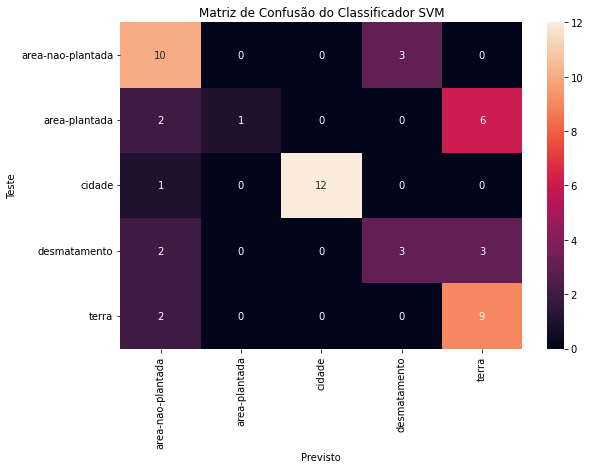

In [ ]:
con_matrix = pd.crosstab(pd.Series(Y_test.values.flatten(), name='Teste' ),pd.Series(y_test_prd, name='Previsto'))
plt.figure(figsize = (9,6))
plt.title("Matriz de Confusão do Classificador SVM")
sns.heatmap(con_matrix, annot=True, fmt='g')
plt.show()

##Colorização da imagem original

Definimos algumas cores para colorizar a imagem original e utilizamos as 5 classes anteriores: área não plantada (cor vinho), área plantada (cor laranja), cidade (azul neon), desmatamento (azul claro) e terra (azul escuro). Com isso, criamos um dicionario para colorir cada uma dessas classes em cores diferentes.

In [ ]:
dv_colors_arr = [
    (68, 34, 136),
    (108, 162, 234),
    (181, 211, 61),
    (254, 210, 63),
    (235, 125, 91)
]

arr = ["area-nao-plantada", "area-plantada", "cidade", "desmatamento", "terra"]

col = dict(zip(arr, dv_colors_arr))
col

{'area-nao-plantada': (68, 34, 136),
 'area-plantada': (108, 162, 234),
 'cidade': (181, 211, 61),
 'desmatamento': (254, 210, 63),
 'terra': (235, 125, 91)}

Utilizando a imagem `itai-sp.png`, processamos cada um dos quadrados de tamanho 20px, tranformamos esse recorte para a escala de cinza, extraimos as características de halarick, aplicamos uma tranformação para obter apenas o componentes principais, utilizando o pca anteriormente criado, predizemos a imagem resultante com o modelo criado anteriormente e aplicamos a cor. O restultado, após aplicação em toda a imagem dividindo em quadrados de tamanho 20px é exibido abaixo:

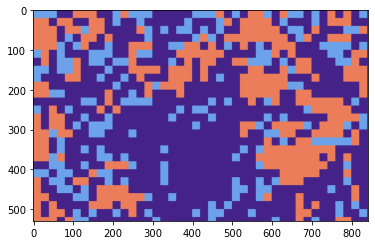

In [ ]:
img = cv2.imread('./itai-sp.png')
arr_predicted = []
for x in range(0, 530, 20):
    for y in range(0, 842, 20):
        patch = img[x:x+20, y:y+20]

        gray = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)

        halarick = extract_features(gray)
        halarick_pca = pca.transform(np.array(halarick).reshape(1,-1))
        y_test_prd = svc.predict(halarick_pca)
        arr_predicted.append(y_test_prd)
        color = col[y_test_prd[0]]

        img[x:x+20, y:y+20] = color

plt.imshow(img)


Abaixo, mostramos que apenas 3 classes foram coloridas, sendo que as outras duas não foram preditas utilizando aquele modelo.

In [ ]:
unique, counts = np.unique(np.array(arr_predicted), return_counts=True)
print(unique, counts)

['area-nao-plantada' 'area-plantada' 'terra'] [661 204 296]


Utilizando a mesma imagem, aplicamos um k-means para obter os 5 clusters que separam a imagem original. Definimos o K como 5, aplicamos o k-means e obtivemos o resultado abaixo.

Centro do cluster 0:
[59 80 63]
Centro do cluster 1:
[141 164 195]
Centro do cluster 2:
[39 48 28]
Centro do cluster 3:
[ 99 120 139]
Centro do cluster 4:
[ 76  99 101]


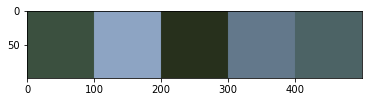

In [ ]:
img = cv2.imread('./itai-sp.png')

Z = img.reshape((-1,3))

Z = np.float32(Z)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 5

ret,label,center=cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

center = np.uint8(center)

res = center[label.flatten()]
res2 = res.reshape((img.shape))

final=np.concatenate((img,res2),axis=1)

plt.imshow(final)

num=center.shape[0]

k=np.ones((10,100,100,3),np.uint8)

for j in range(0,num):
  print("Centro do cluster %d:"%j)
  print(center[j])


for j in range(0,num):
  k[j,:,:,0]=[center[j][0]]
  k[j,:,:,1]=[center[j][1]]
  k[j,:,:,2]=[center[j][2]]

final=np.concatenate((k[0],k[1],k[2],k[3],k[4]),axis=1)

plt.imshow(final)

#Considerações Finais

Analizandos os resultados, pode-se reparar que houve uma boa classificação dos dados a depender do tipo de textura a ser analizada. Com uma precisão acima de 64%, construimos um classificador que, dada uma textura de teste, verifica se a mesma pertence a uma das 5 classes que definimos. Quanto a construção do K-means, o mesmo definiu cores para o centro dos 5 clusters obtidos. Por fim, verificamos como acertiva a realização do trabalho, com o mesmo contribuindo com o entendimento da aplicação de texturas e extração de características de uma imagem para a classificação da mesma utilizando dois classificadores distintos.